# Setup

In [1]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [ ]:
!pip install "numpy<2.0" --force-reinstall

In [2]:
!pip install "opencv-python-headless<4.10"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 36.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
# Configuration for Hyperparameters
CONFIG = {
    "seed": 42,
    "img_size": 380,        
    "batch_size": 16,       
    "epochs": 10,          
    "lr": 1e-4,            
    "model_name": "tf_efficientnet_b4_ns", 
    "num_classes": 5,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# Set the Seed for stable results
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CONFIG['seed'])

# Data Preprocessing & Augmentation

In [4]:
# Augmentation Pipeline
def get_transforms(data='train'):
    if data == 'train':
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.HorizontalFlip(p=0.5),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussNoise(p=0.2),
            A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.3),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            A.Resize(CONFIG['img_size'], CONFIG['img_size']),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

# Prepare Data

In [5]:
# Dataset Class
class GameDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df.loc[idx, 'file_name']
        img_path = os.path.join(self.img_dir, file_name)
  
        if not os.path.exists(img_path):
             image = np.zeros((CONFIG['img_size'], CONFIG['img_size'], 3), dtype=np.uint8)
        else:
             image = cv2.imread(img_path)
             if image is None: # ถ้าอ่านแล้วไฟล์เสีย
                 image = np.zeros((CONFIG['img_size'], CONFIG['img_size'], 3), dtype=np.uint8)
             else:
                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.is_test:
            return image
        else:
            label = self.df.loc[idx, 'label']
            return image, torch.tensor(label, dtype=torch.long)

In [6]:
#Load Data
ROOT_DIR = '/kaggle/input/cpe342-karena/public_dataset/task4'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')

train_df = pd.read_csv(os.path.join(ROOT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(ROOT_DIR, 'test_refined.csv'))

In [7]:
# EDA Check Class Distribution
print("Class Distribution:")
print(train_df['label'].value_counts())

Class Distribution:
label
0    12429
3     5926
2     5596
1     4407
4     3188
Name: count, dtype: int64


This data is highly imbalanced (much more Class 0 than Class 4).

In [8]:
# Stratified Split
train_split, val_split = train_test_split(
    train_df, test_size=0.15, stratify=train_df['label'], random_state=CONFIG['seed']
)
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

# Create Loaders
train_dataset = GameDataset(train_split, TRAIN_DIR, transform=get_transforms('train'))
val_dataset = GameDataset(val_split, TRAIN_DIR, transform=get_transforms('valid'))
test_dataset = GameDataset(test_df, TEST_DIR, transform=get_transforms('valid'), is_test=True)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Class Weights (Imbalance Handling)
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(CONFIG['device'])
print(f"Class Weights: {class_weights}")

Class Weights: [0.50761928 1.4316315  1.12744818 1.06466419 1.97904642]


# Model Training

In [10]:
# Model Definition
class GameClassifier(nn.Module):
    def __init__(self, model_name, num_classes):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True, drop_rate=0.3, drop_path_rate=0.2)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = GameClassifier(CONFIG['model_name'], CONFIG['num_classes'])
model.to(CONFIG['device'])

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

GameClassifier(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNormAct2d(
            48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(48, 

In [15]:
# Training
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-6)

best_f1 = 0.0
print(f"\nTraining ({CONFIG['epochs']} Epochs)")

for epoch in range(CONFIG['epochs']):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]")
    
    for images, labels in pbar:
        images, labels = images.to(CONFIG['device']), labels.to(CONFIG['device'])
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
    
    scheduler.step()
    
    # Validation
    model.eval()
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Valid]"):
            images, labels = images.to(CONFIG['device']), labels.to(CONFIG['device'])
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    epoch_f1 = f1_score(val_labels, val_preds, average='macro')
    avg_train_loss = train_loss / len(train_loader)
    
    print(f"📊 Result: Train Loss: {avg_train_loss:.4f} | Val F1: {epoch_f1:.4f}")
    
    if epoch_f1 > best_f1:
        print(f"Improved! ({best_f1:.4f} -> {epoch_f1:.4f}). Saving model!")
        best_f1 = epoch_f1
        torch.save(model.state_dict(), "task4_best_model.pth")
    
    print("-" * 30)
    
print(f"\nBest F1 Score: {best_f1:.4f}")


Training (10 Epochs)


Epoch 1/10 [Valid]: 100%|██████████| 296/296 [00:50<00:00,  5.92it/s]


📊 Result: Train Loss: 0.4951 | Val F1: 0.9609
Improved! (0.0000 -> 0.9609). Saving model!
------------------------------


Epoch 2/10 [Valid]: 100%|██████████| 296/296 [00:49<00:00,  5.98it/s]


📊 Result: Train Loss: 0.1763 | Val F1: 0.9749
Improved! (0.9609 -> 0.9749). Saving model!
------------------------------


Epoch 3/10 [Valid]: 100%|██████████| 296/296 [00:49<00:00,  5.98it/s]


📊 Result: Train Loss: 0.1156 | Val F1: 0.9814
Improved! (0.9749 -> 0.9814). Saving model!
------------------------------


Epoch 4/10 [Valid]: 100%|██████████| 296/296 [00:49<00:00,  6.00it/s]


📊 Result: Train Loss: 0.0733 | Val F1: 0.9849
Improved! (0.9814 -> 0.9849). Saving model!
------------------------------


Epoch 5/10 [Valid]: 100%|██████████| 296/296 [00:49<00:00,  6.00it/s]


📊 Result: Train Loss: 0.0602 | Val F1: 0.9850
Improved! (0.9849 -> 0.9850). Saving model!
------------------------------


Epoch 6/10 [Valid]: 100%|██████████| 296/296 [00:49<00:00,  5.99it/s]


📊 Result: Train Loss: 0.0441 | Val F1: 0.9888
Improved! (0.9850 -> 0.9888). Saving model!
------------------------------


Epoch 7/10 [Valid]: 100%|██████████| 296/296 [00:49<00:00,  5.99it/s]


📊 Result: Train Loss: 0.0315 | Val F1: 0.9863
------------------------------


Epoch 8/10 [Valid]: 100%|██████████| 296/296 [00:49<00:00,  5.99it/s]


📊 Result: Train Loss: 0.0285 | Val F1: 0.9892
Improved! (0.9888 -> 0.9892). Saving model!
------------------------------


Epoch 9/10 [Valid]: 100%|██████████| 296/296 [00:50<00:00,  5.86it/s]


📊 Result: Train Loss: 0.0258 | Val F1: 0.9922
Improved! (0.9892 -> 0.9922). Saving model!
------------------------------


Epoch 10/10 [Valid]: 100%|██████████| 296/296 [00:49<00:00,  5.99it/s]

📊 Result: Train Loss: 0.0185 | Val F1: 0.9910
------------------------------

Best F1 Score: 0.9922


# Predicting

In [18]:
test_preds = []
model.eval()

with torch.no_grad():
    for images in tqdm(test_loader):
        images = images.to(CONFIG['device'])
        
        # Normal
        output1 = model(images)
        # Horizontal Flip
        output2 = model(torch.flip(images, dims=[3]))
        
        # Average Probabilities
        prob = (torch.softmax(output1, dim=1) + torch.softmax(output2, dim=1)) / 2
        preds = torch.argmax(prob, dim=1)
        test_preds.extend(preds.cpu().numpy())

task4_result = pd.DataFrame({'id': test_df['id'], 'task4': test_preds})
task4_result.to_csv('task4.csv', index=False)
print(task4_result.head())

100%|██████████| 1619/1619 [08:52<00:00,  3.04it/s]


         id  task4
0  ANS00001      0
1  ANS00002      3
2  ANS00003      3
3  ANS00004      0
4  ANS00005      3


# Evaluation & Visualization

Evaluating: 100%|██████████| 592/592 [01:00<00:00,  9.80it/s]


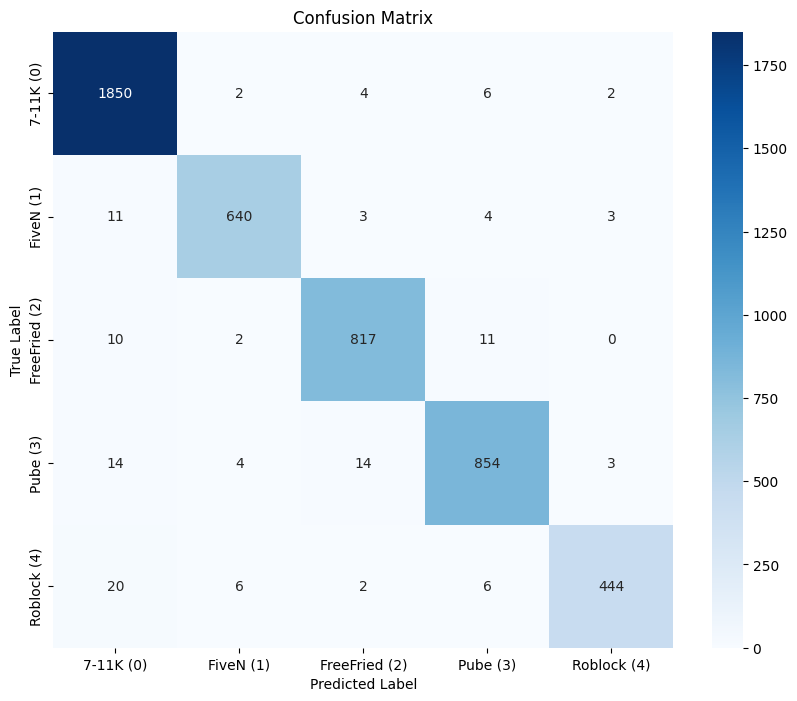


Classification Report:
               precision    recall  f1-score   support

    7-11K (0)       0.97      0.99      0.98      1864
    FiveN (1)       0.98      0.97      0.97       661
FreeFried (2)       0.97      0.97      0.97       840
     Pube (3)       0.97      0.96      0.96       889
  Roblock (4)       0.98      0.93      0.95       478

     accuracy                           0.97      4732
    macro avg       0.97      0.96      0.97      4732
 weighted avg       0.97      0.97      0.97      4732



In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

val_preds = []
val_labels = []
class_names = ["7-11K (0)", "FiveN (1)", "FreeFried (2)", "Pube (3)", "Roblock (4)"]

eval_batch_size = CONFIG['batch_size'] // 2 
val_loader_safe = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=2)

with torch.no_grad():
    for images, labels in tqdm(val_loader_safe, desc="Evaluating"):
        images, labels = images.to(CONFIG['device']), labels.to(CONFIG['device'])
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Plot Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names))